In [1]:
#simulations infrastructure
import splat
import wisps.simulations as wispsim
from astropy.coordinates import SkyCoord

import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import wisps
import pandas as pd

import seaborn as sns
%matplotlib inline
import splat.photometry as sphot
import splat.core as spl
import splat.empirical as spe
import splat.simulate as spsim
import matplotlib as mpl
from tqdm import tqdm

#matplotlib defaults
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['axes.linewidth'] = 0.9
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 18
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'
mpl.rcParams['xtick.bottom']=True
mpl.rcParams['xtick.major.width']=0.9
mpl.rcParams['xtick.minor.width']=0.9
mpl.rcParams['ytick.major.width']=0.9
mpl.rcParams['ytick.minor.width']=0.9
mpl.rcParams['ytick.right']=True
mpl.rcParams['xtick.direction']='in'
mpl.rcParams['ytick.direction']='in'


from astropy import stats as astrostats

In [2]:
grid=np.sort(np.random.uniform(1000, 4000,1000))

In [3]:
#plt.plot(grid, splat_teff_to_spt(grid))
#plt.xlim(10, 40)

### Generate a spectral type, HST mags relation <br>
Using spex templates/standards


In [4]:
kirkpa2019pol={'pol':np.poly1d(np.flip([36.9714, -8.66856, 1.05122 ,-0.0344809])), 
                'scatter':.67, 'range':[36, 44]}

In [5]:
def absolute_mag_dupuy(spt, filt):
    #use the uncertainty in dupuy relation 
    val, unc=spe.typeToMag(spt,filt,set='dupuy')
    return np.random.normal(val, unc)

def absolute_mag_kirkpatrick(spt, filt):
    if filt != '2MASS H':
        return np.nan
    else:
        if (spt > 36) and (spt <44):
            pol=kirkpa2019pol['pol']
            unc=kirkpa2019pol['scatter']
            return np.random.normal(pol(spt-30), unc)
            
        else:
            return np.nan
        
def absolute_mag_relation(spt, filt):
    spt=wisps.make_spt_number(spt)
    #try dupuy up to T7
    if spt < 37:
        return absolute_mag_dupuy(spt, filt)
    else: 
        return absolute_mag_kirkpatrick(spt, filt)
    

In [6]:
def flux_calibrate_spectrum(filename):
    try:
        sp=splat.getSpectrum(filename=filename)[0]
        spt=splat.typeToNum(sp.spex_type)
        sp.fluxCalibrate('2MASS J',float(sp.j_2mass))
        return [spt, sp]
    except:
        return []

In [7]:
def schn_flux_calibrate(row):
    sp=row.spectra.splat_spectrum
    spt=splat.typeToNum(row.Spec)
    sp.fluxCalibrate('MKO J',float(row.J_MKO))
    return [spt, sp]

In [8]:
splat_db=splat.searchLibrary(vlm=True, giant=False, young=False)

In [9]:
schn_ydwarfs=pd.read_pickle(wisps.LIBRARIES+'/schneider.pkl')

In [10]:
%%capture
sml=splat_db[(~ splat_db.PARALLAX.isna())]
calbr=sml.DATA_FILE.apply(flux_calibrate_spectrum)

In [11]:
calbrschn=schn_ydwarfs.apply(schn_flux_calibrate, axis=1)

In [12]:
combcal=np.append(calbr, calbrschn)

In [13]:
len(calbr.values)

322

In [14]:
specs=np.array([x for x in pd.DataFrame(combcal).values if x])

In [15]:
from astropy.io import ascii

In [16]:
mamjk=ascii.read('/users/caganze/research/wisps/data/mamajek_relations.txt').to_pandas().replace('None', np.nan)

In [17]:
def make_mamajek_fit(spt):
    
    js=mamjk.M_J.apply(float).values
    jminush=mamjk['J-H'].apply(float).values
    hs=js-jminush
    
    spts=mamjk.SpT.apply(wisps.make_spt_number).apply(float).values
    
    hsortedindex=np.argsort(hs)
    jsortedindex=np.argsort(js)
    
    hval=np.interp(spt,  spts[hsortedindex], hs[hsortedindex])
    jval=np.interp(spt,  spts[jsortedindex], js[jsortedindex])
    
    return [jval, hval]

In [18]:
#transform dupuy relation into HST mags
def get_colors(sp, flt):
    #using splat filtermag
    mag, mag_unc = splat.filterMag(sp, flt)
    #calculate the mag of the standard in J and H
    
    magj, mag_uncj = splat.filterMag(sp,'2MASS J')
    magh, mag_unch = splat.filterMag(sp,'2MASS H')
    #calculate the offset between HST filters and 2mass filters but add the uncertainty
    
    offsetj=magj-mag
    offseth=magh-mag
    
    unc1=(mag_unc**2+mag_uncj**2)**0.5
    unc2=(mag_unc**2+mag_unch**2)**0.5
    
    #offsetj=np.random.normal(offsetj, unc1)
    #offseth=np.random.normal(offseth, unc2)
    return [[offsetj, offseth], [unc1, unc2]]

In [19]:
def get_abs_hst_mag(color, mag0):
    return mag0-color

In [20]:
colors=[]
uncolors=[]
fltrs= ['WFC3_{}'.format(k) for k in ['F110W', 'F140W', 'F160W']]
for pair in tqdm(specs):
    c=[]
    uncclrs=[]
    for flt in fltrs:
        x=pair[0][1]
        sptx=pair[0][0]
        color, uncc=get_colors(x, flt)
        c.append(color)
        uncclrs.append(uncc)
    uncolors.append(uncclrs)
    colors.append(c)
#abs_hstmags=[get_abs_hst_mag(splat.typeToNum(x)) for x in  sp_grid]

100%|██████████| 343/343 [04:57<00:00,  1.15it/s]


In [21]:
colors=np.array(colors)
uncolors=np.array(uncolors)

In [22]:
spts=np.array([pair[0][0] for pair in specs])

In [23]:
spgrididx=np.argsort(spts)
sp_grid=spts[spgrididx]
colors=colors[spgrididx]
uncolors=uncolors[spgrididx]

In [24]:
#plt.hist(uncolors.flatten())

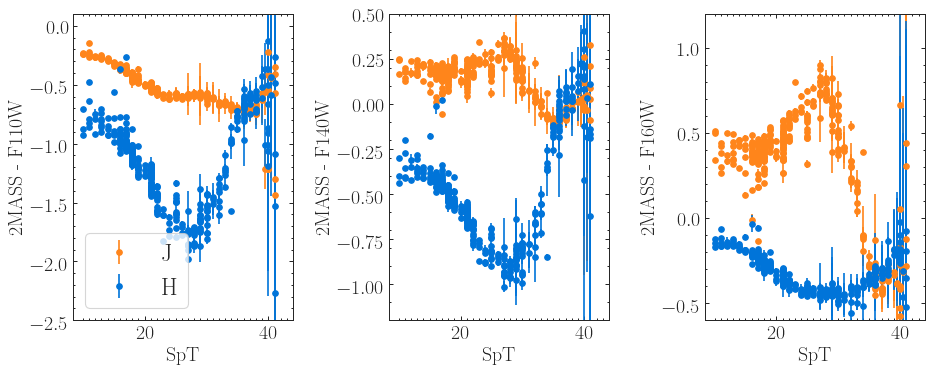

In [25]:
fig, ax=plt.subplots(ncols=3, figsize=(12, 5), sharey=False)
for a in ax:
    a.set_xlabel('SpT')

ax[0].set_ylabel('2MASS - F110W')
ax[0].errorbar(sp_grid, colors[:,0][:,0], yerr= uncolors[:,0][:,0], label='J',fmt='o', c='#FF851B', ms=5)
ax[0].errorbar(sp_grid, colors[:,0][:,1], yerr=uncolors[:,0][:,1],  label='H',fmt='o', c='#0074D9', ms=5)

ax[1].set_ylabel('2MASS - F140W')
ax[1].errorbar(sp_grid, colors[:,1][:,0], yerr=uncolors[:,1][:,0], label='J',fmt='o', c='#FF851B', ms=5)
ax[1].errorbar(sp_grid, colors[:,1][:,1], yerr=uncolors[:,1][:,1], label='H',fmt='o', c='#0074D9', ms=5)

ax[2].set_ylabel('2MASS - F160W')
ax[2].errorbar(sp_grid, colors[:,2][:,0], yerr=uncolors[:,2][:,0], label='J',fmt='o', c='#FF851B', ms=5)
ax[2].errorbar(sp_grid, colors[:,2][:,1], yerr=uncolors[:,2][:,1], label='H',fmt='o', c='#0074D9', ms=5)

ax[0].legend()

for a in ax:
    a.set_xticks(np.arange(10, 45, 1), minor=True)
    a.set_yticks(np.arange(-3, 1.0, 0.1), minor=True)
    a.yaxis.set_ticks_position('both')
    a.xaxis.set_ticks_position('both')
    #a.tick_params(which='major',direction='inout')
    a.tick_params(which='minor', direction='in')
    
ax[0].set_ylim([-2.5, 0.1])
ax[1].set_ylim([-1.2, 0.5])
ax[2].set_ylim([-0.6, 1.2])
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/mass_hubble_colors.pdf')

### Generate apparent HST mags<br>
Using candidates?

In [26]:
jsdupuy = [absolute_mag_relation(x, '2MASS J') for x in sp_grid]
hsdupuy= [absolute_mag_relation(x, '2MASS H') for x in sp_grid]

In [27]:
mamjk.columns

Index(['SpT', 'Teff', 'logT', 'logL', 'Mbol', 'BCv', 'Mv', 'B-V', 'Bt-Vt',
       'G-V', 'Bp-Rp', 'G-Rp', 'M_G', 'b-y', 'U-B', 'V-Rc', 'V-Ic', 'V-Ks',
       'J-H', 'H-Ks', 'Ks-W1', 'W1-W2', 'W1-W3', 'W1-W4', 'M_J', 'M_Ks', 'i-z',
       'z-Y', 'R_Rsun', 'Msun', 'SpTn'],
      dtype='object')

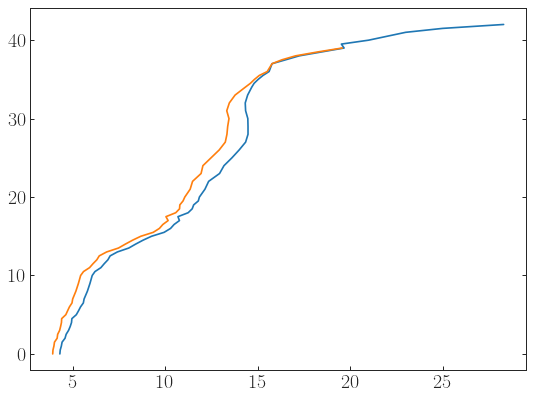

In [28]:
plt.plot(mamjk.M_J.values, mamjk.SpT.apply(wisps.make_spt_number).apply(float).values)
plt.plot(mamjk.M_J.apply(float).values-mamjk['J-H'].apply(float).values,
         mamjk.SpT.apply(wisps.make_spt_number).apply(float).values)

In [29]:
jhsmamj=np.vstack([ make_mamajek_fit(x) for x in sp_grid])

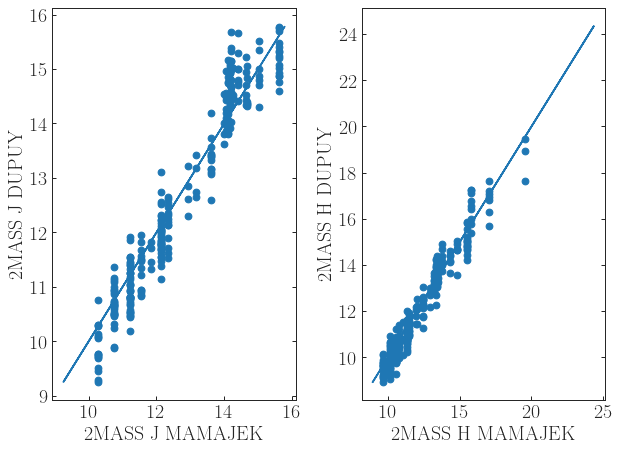

In [30]:
fig, ax=plt.subplots(ncols=2)
ax[0].scatter(jhsmamj[:, 0], jsdupuy)
ax[0].plot(jsdupuy , jsdupuy )
ax[0].set_ylabel('2MASS J  DUPUY')
ax[0].set_xlabel('2MASS J  MAMAJEK')

ax[1].scatter(jhsmamj[:, 1], hsdupuy)
ax[1].plot(hsdupuy, hsdupuy)
ax[1].set_ylabel('2MASS H  DUPUY')
ax[1].set_xlabel('2MASS H  MAMAJEK')

plt.tight_layout()

In [31]:
len(jhsmamj[:, 0]), len(sp_grid), #jhsmamj[:, 0]

(343, 343)

In [32]:
js=jhsmamj[:,0]
hs=jhsmamj[:,1]

In [33]:
abs_hstmagsj=np.array([np.array(js)-x for x  in colors[:, :,0].T]).T
abs_hstmagsh=np.array([np.array(hs)-x for x  in colors[:, :,1].T]).T

In [34]:
abs_hstmagsjunc=(uncolors[:, :, 0]**2+0.4**2)**0.5 #the intrinsic scatter is not the std
abs_hstmagshunc=(uncolors[:, :, 1]**2+0.4**2)**0.5 #the instrinsic scatter is but the mean of errors

In [35]:
abs_hstmagshunc

array([[0.4000287 , 0.40002848, 0.40003307],
       [0.40000103, 0.40000086, 0.40000081],
       [0.40000268, 0.40000265, 0.40000269],
       ...,
       [1.18879024, 1.07325306, 1.16441223],
       [1.28813943, 1.43766357, 1.41115767],
       [1.53929665, 1.46532409, 1.52442926]])

In [36]:
np.nanmean(js), np.nanstd(js)

(12.964198250728867, 3.093797686333409)

In [37]:
abs_hstmagsjunc.shape, abs_hstmagshunc.shape, abs_hstmagsh.shape, abs_hstmagsh.shape, abs_hstmagsj.shape

((343, 3), (343, 3), (343, 3), (343, 3), (343, 3))

In [38]:
def get_app_hst_mag(dist, absmag):
    ##returns apparent HST mag given distance and absolute mag
    return np.log10(dist-1)*5+absmag

## Visualization

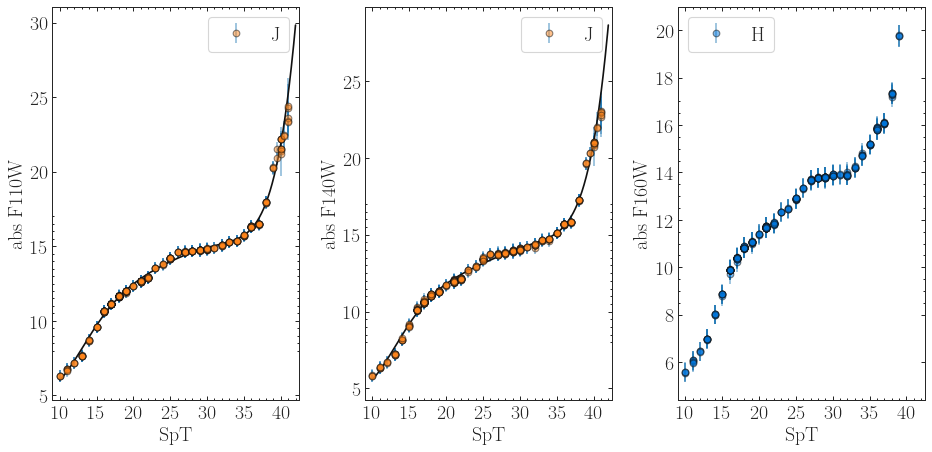

In [39]:
fig, ax=plt.subplots(ncols=3, sharey=False, figsize=(12, 6))
for a in ax:
    a.set_xlabel('SpT')

#ax[0].plot( sp_grid, np.array(js))
#ax[1].plot( sp_grid, np.array(hs))

#ax[0].set_ylabel('abs J')
#ax[1].set_ylabel('abs H')

ax[0].errorbar( sp_grid, abs_hstmagsj[:,0], yerr=abs_hstmagsjunc[:,0], fmt='o',  mec='#111111', mfc='#FF851B', label='J', alpha=0.5)
ax[1].errorbar( sp_grid, abs_hstmagsj[:,1], yerr=abs_hstmagsjunc[:,1], fmt='o',  mec='#111111',  mfc='#FF851B', label='J', alpha=0.5)

ax[2].errorbar(sp_grid, abs_hstmagsh[:,2], yerr=abs_hstmagshunc[:, 2],fmt='o',mec='#111111',  mfc='#0074D9', label='H', alpha=0.5)

ax[0].set_ylabel('abs F110W')
ax[1].set_ylabel('abs F140W')
ax[2].set_ylabel('abs F160W')


grids=np.linspace(10, 42, 1000)

SIGMA0=np.nanmean(abs_hstmagsjunc[:,0])
p4=wisps.fit_polynomial( sp_grid, abs_hstmagsj[:,0], n=6, y_unc=abs_hstmagsjunc[:,0])
ax[0].plot(grids, p4(grids), c='#111111')
#ax[0].fill_between(grids, p4(grids)+SIGMA0, p4(grids)-SIGMA0, alpha=0.1)

SIGMA1=np.nanmean(abs_hstmagsjunc[:,1])
p5=wisps.fit_polynomial(sp_grid, abs_hstmagsj[:,1], n=6,  y_unc=abs_hstmagsjunc[:,1])
ax[1].plot( grids, p5(grids),c='#111111')
#ax[1].fill_between(grids, p5(grids)+SIGMA1, p5(grids)-SIGMA1, alpha=0.1)

SIGMA2=np.nanmean(abs_hstmagshunc[:,2])
p6=wisps.fit_polynomial( sp_grid, abs_hstmagsh[:,2], n=6,  y_unc=abs_hstmagshunc[:,2])
ax[2].plot( grids, p6(grids),  c='#111111')
#ax[2].fill_between(grids, p6(grids)+SIGMA2, p6(grids)-SIGMA2, alpha=0.1 )



for a in ax:
    a.set_xticks(np.arange(10, 45, 1), minor=True)
    a.set_xticks(np.arange(10, 45, 5), minor=False)
    a.set_yticks(np.arange(8, 17.5, 0.5), minor=True)
    a.yaxis.set_ticks_position('both')
    a.xaxis.set_ticks_position('both')
    #a.tick_params(which='major',direction='inout')
    a.tick_params(which='minor', direction='in')
    
    a.legend(fontsize=18)
    a.set_xlim([9, 42.5])

plt.tight_layout()

plt.savefig(wisps.OUTPUT_FIGURES+'/hst_relations.pdf')

In [40]:
#app_hstmags[:,2].shape

In [41]:
#fig, ax=plt.subplots(ncols=3, figsize=(12, 3), sharex=True)
#for a in ax:
#    a.invert_yaxis()
#    a.set_xscale('log')
#for i in np.arange(0, 18):
#    ax[0].plot(ds, np.array(app_hstmags)[:,i][0], color='#0074D9', alpha=0.4)
#    ax[1].plot(ds, np.array(app_hstmags)[:,i][1],  color='#0074D9', alpha=0.4)
#    ax[2].plot(ds, np.array(app_hstmags)[:,i][2],  color='#0074D9', alpha=0.4)

#ax[0].set_xlabel('distance (pc)')
#ax[1].set_xlabel('distance (pc)')
#ax[2].set_xlabel('distance (pc)')

#ax[0].set_ylabel('F110W')
#ax[1].set_ylabel('F140W')
#ax[2].set_ylabel('F160W')
#plt.tight_layout()

## Using my sample to map to SNR and sigma_error on app mags

In [42]:
import wisps

In [43]:
from astropy.table import Table
tab = Table.read(wisps.LIBRARIES+'/candidates.tex').to_pandas()

In [44]:
cands=tab

In [45]:
cands.columns

Index(['Shortname', 'grism id', 'snrj', 'spt', 'ra', 'dec', 'f110', 'f110\_er',
       'f140', 'f140\_er', 'f160', 'f160\_er', 'distance', 'distance\_er',
       '2MASS j', '2MASS h\_ER', '2MASS j\_ER'],
      dtype='object')

In [46]:
#some reformatting
obs_F110W=np.array([cands.f110.values, cands['f110\_er'].values ]).T
obs_F140W=np.array([cands.f140.values, cands['f140\_er'].values ]).T
obs_F160W=np.array([cands.f160.values, cands['f160\_er'].values ]).T

In [47]:

mags=np.linspace(10, 27, 100)

In [48]:
snrs=cands.snrj.values

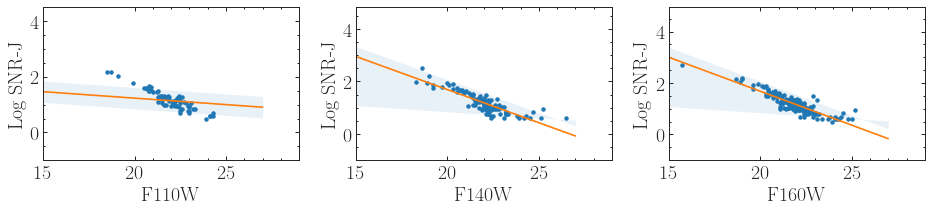

In [56]:
fig, ax=plt.subplots(ncols=3, figsize=(12, 3))

for a in ax:
    a.set_ylabel(r'Log SNR-J')
    a.set_xlim([15, 27])
    #a.set_ylim([0, 500])

ax[0].plot(obs_F110W[:,0], np.log10(snrs), '.')
ax[1].plot(obs_F140W[:,0], np.log10(snrs), '.')
ax[2].plot(obs_F160W[:,0], np.log10(snrs), '.')


p0=wisps.fit_polynomial(obs_F110W[:,0], np.log10(snrs), n=1, sigma_clip=True, sigma=5)
ax[0].plot(mags, p0(mags))
ax[0].fill_between(mags, p0(mags)+np.std(np.log10(snrs)), p0(mags)-np.std(np.log10(snrs)), alpha=0.1 )


p1=wisps.fit_polynomial(obs_F140W[:,0], np.log10(snrs), n=1,  sigma_clip=True, sigma=5)
ax[1].plot(mags, p1(mags))
ax[1].fill_between(mags, p1(mags)+np.std(np.log10(snrs)), p0(mags)-np.std(np.log10(snrs)), alpha=0.1 )


p2=wisps.fit_polynomial(obs_F160W[:,0], np.log10(snrs), n=1,  sigma_clip=True, sigma=5)
ax[2].plot(mags, p2(mags))
ax[2].fill_between(mags, p2(mags)+np.std(np.log10(snrs)), p0(mags)-np.std(np.log10(snrs)), alpha=0.1 )

for a in ax:
    a.set_xticks(np.arange(20, 30, 1), minor=True)
    a.set_yticks(np.arange(-1, 5, 0.5), minor=True)
    a.yaxis.set_ticks_position('both')
    a.xaxis.set_ticks_position('both')
    #a.tick_params(which='major',direction='inout')
    a.tick_params(which='minor', direction='in')
    
ax[0].set_xlabel('F110W')
ax[1].set_xlabel('F140W')
ax[2].set_xlabel('F160W')

plt.tight_layout()

plt.savefig(wisps.OUTPUT_FIGURES+'/snr_fits.pdf')

In [51]:
polrealtions={'snr_F110W':p0, 'snr_F140W':p1, 'snr_F160W':p2, \
             'sp_F110W':p4, 'sigma_log_f110':  np.std(np.log10(snrs)),
              'sigma_log_f140':  np.std(np.log10(snrs)),
              'sigma_log_f160':  np.std(np.log10(snrs)),
              'sp_F140W':p5, 'sigma_sp_F140W':SIGMA1, 'sp_F160W':p6, 
              'sigma_sp_F160W':SIGMA2,
             'sigma_sp_F110W':SIGMA0 }

In [52]:
polrealtions

{'snr_F110W': poly1d([-0.01948568,  0.56986169, -1.93458271]),
 'snr_F140W': poly1d([ 0.02524522, -1.36255952, 18.89785712]),
 'snr_F160W': poly1d([ 1.02681325e-02, -7.04396841e-01,  1.16675349e+01]),
 'sp_F110W': poly1d([ 5.90115147e-07, -8.33829280e-05,  4.79816548e-03, -1.42949131e-01,
         2.28976760e+00, -1.78262782e+01,  5.80332085e+01]),
 'sigma_log_f110': 0.3833218554591111,
 'sigma_log_f140': 0.3833218554591111,
 'sigma_log_f160': 0.3833218554591111,
 'sp_F140W': poly1d([ 6.25938051e-07, -8.93648448e-05,  5.18296986e-03, -1.55103929e-01,
         2.48829628e+00, -1.94424343e+01,  6.27972043e+01]),
 'sigma_sp_F140W': 0.41964744601693554,
 'sp_F160W': poly1d([nan, nan, nan, nan, nan, nan, nan]),
 'sigma_sp_F160W': 0.4307792043295404,
 'sigma_sp_F110W': 0.4246899558598775}